# Reading

i. MIDI-audio alignment is the first step in the process of onset alignment. An audio signal is processed so that its onsets and offsets can be matched to data in a given MIDI representation of an audio file. Through this process, it is possible via various models to estimate timing differences (or asynchronies) between the MIDI file, which is usually more quantized, and the audio.

ii. Hidden Markov models are often used for MIDI-audio alignment. HMMs allow us to create a probabalistic model of all the possible discrete state changes, modeled in the paper as transitions to and from 3 states: onset (attack), offset (decay) and note off. Dynamic time warping is a variation of HMMs that is also used for MIDI-audio alignment, where probability of state changes is constant.

iii. Online alignment is done in realtime, typically with the goal of accompanying a live performer or tracking a score. This is often accomplished with graphical models and hidden Markov models to create an estimation of timing structures. Offline alignment is used for analysis purposes when live tracking is not a goal, such as studying a performance or creatinga reference for signal processing algorithms. Dynamic time warping is often used for this technique.

# Python Exercise

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas
import IPython.display

In [26]:
def getOnsetsEnv(sig,sr=44100):

    o_env = librosa.onset.onset_strength(sig, sr=sr)
    times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

    D = np.abs(librosa.stft(sig,n_fft=4096))
    plt.figure()
    ax1 = plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), hop_length=512, x_axis='time', y_axis='log')
    plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(times, o_env, label='Detection function')
    plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='Onsets')
    plt.axis('tight')
    plt.legend(frameon=True, framealpha=0.75)
    
    return onset_frames

In [27]:
def getOnsetsWrapper(filename):
    sig , sr = librosa.load(filename,mono=True,sr=None)
    
    # estimate onsets from an onset envelope
    onset_frames = getOnsetsEnv(sig,sr)
    print('Estimated onsets:')
    print(librosa.frames_to_time(onset_frames, sr=sr))

In [28]:
def readOnsetCSV(audiofilename,csvfilename):

    sig , sr = librosa.load(audiofilename,mono=True,sr=None)

    df = pandas.read_csv(csvfilename,header=None)
    times = df.loc[:,0]

    D = np.abs(librosa.stft(sig,n_fft=4096))
    
    return sig, sr, times

In [48]:
def getAudio(file):

    sig, sr, times = readOnsetCSV(file + '.wav', file + '_vamp_qm-vamp-plugins_qm-onsetdetector_onsets.csv')

    y, sr = librosa.load(file + '.wav')
    samp = np.zeros(len(y))
    sampLoc=librosa.time_to_samples(times.values, sr=sr)
    samp[sampLoc]=1
    
    newSig=np.zeros((len(y),2))
    newSig[:,0]=samp
    newSig[:,1]=y
    meanNewSig=np.mean(newSig,1)
    
    dataleft = y
    dataright = meanNewSig
    
    return IPython.display.Audio([dataleft, dataright], rate=sr)

In [49]:
def makeGraphs(file):
    
    getOnsetsWrapper(file + '.wav')
    
    sig, sr = librosa.load(file + '.wav', mono=True,sr=None)
    
    intensitydf = pandas.read_csv(file + "_vamp_bbc-vamp-plugins_bbc-intensity_intensity.csv",header=None)
    intensityVals = intensitydf.values
    
    rmsdf = pandas.read_csv(file + "_vamp_bbc-vamp-plugins_bbc-energy_rmsenergy.csv",header=None) 
    rmsVals = rmsdf.values
    
    loudnessdf = pandas.read_csv(file + "_vamp_vamp-libxtract_loudness_loudness.csv", header=None)
    loudnessVals = loudnessdf.values
    
    D = np.abs(librosa.stft(sig,n_fft=4096))
    plt.suptitle('Onset estimates for ' + file + '.wav')
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), x_axis='time', y_axis='log',cmap='gray')
    plt.hold
    plt.plot(intensityVals[:,0],intensityVals[:,1],color = 'm')
    plt.plot(rmsVals[:,0],rmsVals[:,1]*1000,color = 'g')
    plt.plot(loudnessVals[:,0],loudnessVals[:,1]*100,color = 'y')
    plt.title('Loudness-related estimates for ' + file + '.wav')
    plt.tight_layout()
    

Estimated onsets:
[0.23219955 0.42956916 0.65015873 0.85913832 1.06811791 1.28870748
 1.4860771  1.70666667 1.91564626 2.11301587 2.34521542 2.54258503
 2.7631746  2.96054422 3.19274376 3.39011338 3.61070295 3.80807256
 4.02866213 4.23764172 4.44662132 4.65560091 4.85297052 4.89941043
 5.09678005 5.29414966 5.50312925 5.72371882 5.92108844 6.141678
 6.3506576  6.55963719]


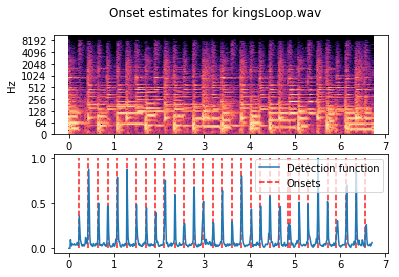

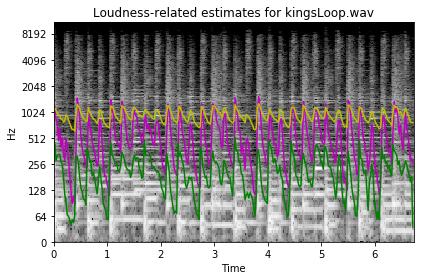

In [50]:
makeGraphs('kingsLoop')
getAudio('kingsloop')

Estimated onsets:
[ 0.12770975  0.54566893  0.58049887  0.92879819  1.10294785  1.20743764
  1.42802721  2.06657596  2.28716553  2.38004535  2.51936508  2.75156463
  2.83283447  3.25079365  3.39011338  3.57587302  3.75002268  3.80807256
  3.86612245  4.16798186  4.27247166  4.34213152  4.52789116  4.84136054
  5.23609977  5.43346939  5.57278912  5.74693878  6.93115646  7.58131519
  8.02249433  8.12698413  8.19664399  8.2430839   8.37079365  8.63782313
  8.96290249  9.19510204  9.3692517   9.63628118  9.84526077 10.32126984
 10.43736961 10.89015873 11.29650794]


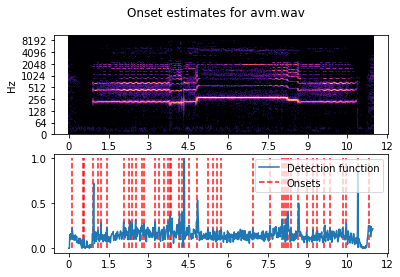

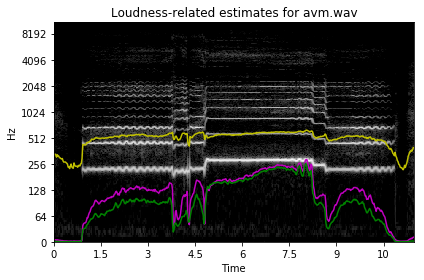

In [51]:
makeGraphs('avm')
getAudio('avm')

Estimated onsets:
[0.03482993 0.27863946 0.40634921 0.510839   0.6153288  0.74303855
 0.84752834 0.9752381  1.07972789 1.18421769 1.30031746 1.40480726
 1.52090703 1.62539683 1.7414966  1.86920635 2.13623583 2.22911565
 2.33360544 2.44970522 2.56580499 2.67029478 2.78639456 2.87927438
 2.99537415 3.09986395 3.20435374 3.32045351 3.42494331 3.54104308
 3.65714286 3.92417234 4.02866213 4.13315193 4.2492517  4.34213152
 4.45823129 4.57433107 4.67882086 4.79492063 4.89941043 5.00390023
 5.24770975 5.36380952 5.49151927 5.74693878 5.85142857 5.97913832
 6.07201814 6.17650794 6.28099773 6.39709751 6.5015873  6.6060771
 6.72217687 6.80344671 6.93115646 7.04725624 7.17496599 7.30267574]


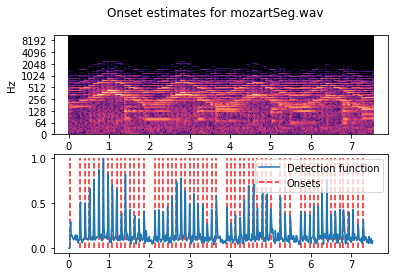

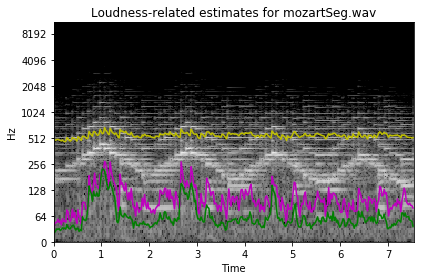

In [52]:
makeGraphs('mozartSeg')
getAudio('mozartSeg')

Estimated onsets:
[0.04643991 0.09287982 0.19736961 0.77786848 0.91718821 1.10294785
 1.20743764 1.32353741 1.4860771  1.67183673 1.83437642 1.98530612
 2.08979592 2.31038549 2.40326531 2.78639456 2.91410431 3.2275737
 3.43655329 3.50621315 3.56426304 3.71519274 3.87773243 4.15637188
 4.2492517  4.5046712  4.58594104]


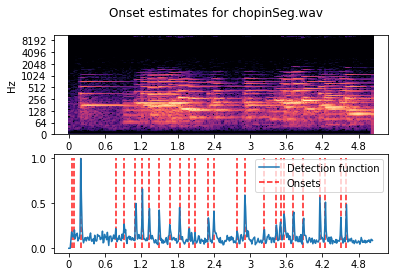

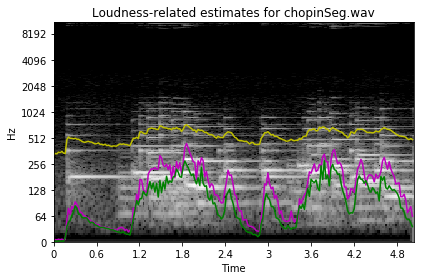

In [54]:
makeGraphs('chopinSeg')
getAudio('chopinSeg')